In [1]:
import numpy as np

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import time

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

device = torch.device('cpu')

In [2]:
epochs = 1000
lr = 3e-5
block_size = 30

import random
torch.manual_seed(42)

In [3]:
d, m, k = 1000, 1000, 50

A = torch.randn(d, m, device=device)
X = torch.randn(d, k, device=device)
E = torch.randn(m, k, device=device)

noised_matrix = torch.mm(A, X) + E

In [4]:
b_i = torch.argmax(noised_matrix, dim=1)

Z = torch.zeros(d, k, device=device)
Z[torch.arange(d), b_i] = 1 

In [5]:
def f(X, A, b_i):
    logits = torch.mm(A, X)
    log_probs = -F.log_softmax(logits, dim=1)
    loss = (log_probs * Z).sum() / Z.sum()
    return loss

def P(X, A):
    return F.softmax(torch.mm(A, X), dim = 1)

def gradient(X, A, Z):
    logits = torch.mm(A, X)
    probs = F.softmax(logits, dim=1)
    grad = torch.mm(A.t(), probs - Z)
    return grad

In [6]:
def evaluate_accuracy(X, A, b_i):
    with torch.no_grad():
        logits = torch.mm(A, X)
        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == b_i).float().mean().item()
    return accuracy

In [7]:
def GD(X, A, Z, b_i, epochs, lr):
    accuracies = []
    times = []
    start_time = time.process_time()
    for epoch in range(epochs):
        update = gradient(X, A, Z)
        X -= lr * update
        current_time = time.process_time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)

        accuracies.append(accuracy)
        times.append(current_time)
    return accuracies, times


In [8]:
def BCGD_randomized(X, A, Z, b_i, epochs, lr, block_size):
    accuracies = []
    times = []
    start_time = time.process_time()
    for epoch in range(epochs):
        block_indices = torch.randint(0, X.shape[1], (block_size,)).tolist()
        update_block = gradient(X[:, block_indices], A, Z[:, block_indices])
        X[:, block_indices] -= lr * update_block
        current_time = time.process_time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)

        accuracies.append(accuracy)
        times.append(current_time)
    return accuracies, times


In [9]:
def BCGD_Gauss_Southwell(X, A, Z, b_i, epochs, lr, block_size):
    accuracies = []
    times = []
    start_time = time.process_time()
    for epoch in range(epochs):
        norms = torch.norm(gradient(X, A, Z), dim=0)
        _, block_indices = torch.topk(norms, block_size, largest=True)
        update_block = gradient(X[:, block_indices], A, Z[:, block_indices])
        X[:, block_indices] -= lr * update_block
        current_time = time.process_time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)

        accuracies.append(accuracy)
        times.append(current_time)
        
    return accuracies, times

In [10]:
def calculate_lipschitz(A):
    _, S, _ = torch.svd(A)
    return S.max().item() ** 2

L = calculate_lipschitz(A)

def block_stepsize(A, block_indices):
    col_norms = torch.norm(A[:, block_indices], dim=0) ** 2
    return 1 / col_norms

def exact_stepsize(A, X):
    diag = torch.diag(torch.mm(A.t(), A))
    return 1 / diag

X_init = torch.randn(d, k, device=device)

alpha_fixed = 1 / L

block_indices = torch.randint(0, k, (block_size,))
alpha_block = block_stepsize(A, block_indices)

alpha_exact = exact_stepsize(A, X_init)

In [11]:
def RUN(X_init, A, Z, b_i, epochs, block_size):
    results = {'GD': {}, 'BCGD_randomized': {}, 'BCGD_Gauss_Southwell': {}}

    X_fixed = X_init.clone()
    results['GD']['Fixed'] = GD(X_fixed, A, Z, b_i, epochs, alpha_fixed)
    X_fixed = X_init.clone()
    results['BCGD_randomized']['Fixed'] = BCGD_randomized(X_fixed, A, Z, b_i, epochs, alpha_fixed, block_size)
    X_fixed = X_init.clone()
    results['BCGD_Gauss_Southwell']['Fixed'] = BCGD_Gauss_Southwell(X_fixed, A, Z, b_i, epochs, alpha_fixed, block_size)

    X_block = X_init.clone()
    results['GD']['Block'] = GD(X_block, A, Z, b_i, epochs, alpha_block.mean().item())
    X_block = X_init.clone()
    results['BCGD_randomized']['Block'] = BCGD_randomized(X_block, A, Z, b_i, epochs, alpha_block.mean().item(),
                                                          block_size)
    X_block = X_init.clone()
    results['BCGD_Gauss_Southwell']['Block'] = BCGD_Gauss_Southwell(X_block, A, Z, b_i, epochs,
                                                                    alpha_block.mean().item(), block_size)

    X_exact = X_init.clone()
    results['GD']['Exact'] = GD(X_exact, A, Z, b_i, epochs, alpha_exact.mean().item())
    X_exact = X_init.clone()
    results['BCGD_randomized']['Exact'] = BCGD_randomized(X_exact, A, Z, b_i, epochs, alpha_exact.mean().item(),
                                                          block_size)
    X_exact = X_init.clone()
    results['BCGD_Gauss_Southwell']['Exact'] = BCGD_Gauss_Southwell(X_exact, A, Z, b_i, epochs,
                                                                    alpha_exact.mean().item(), block_size)

    return results


In [12]:
results = RUN(X_init, A, Z, b_i, epochs, block_size)

In [13]:
def plot_results(results, stepsize_name):
    plt.figure(figsize=(10, 6))

    for algo_name, (accuracies, times) in results.items():
        plt.plot(times, accuracies, label=algo_name)

    plt.title(f'Accuracy vs Time for {stepsize_name} Stepsize')
    plt.xlabel('Seconds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


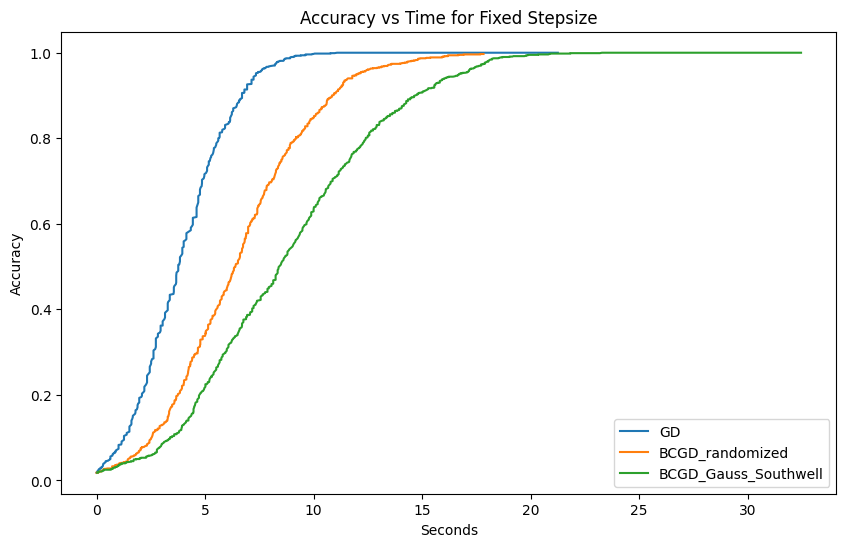

In [14]:
plot_results({k: v['Fixed'] for k, v in results.items()}, 'Fixed')

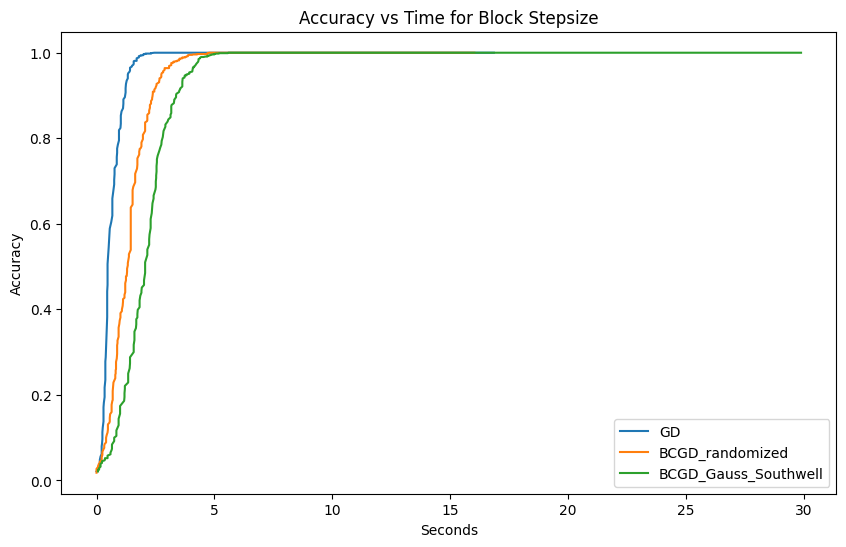

In [15]:
plot_results({k: v['Block'] for k, v in results.items()}, 'Block')

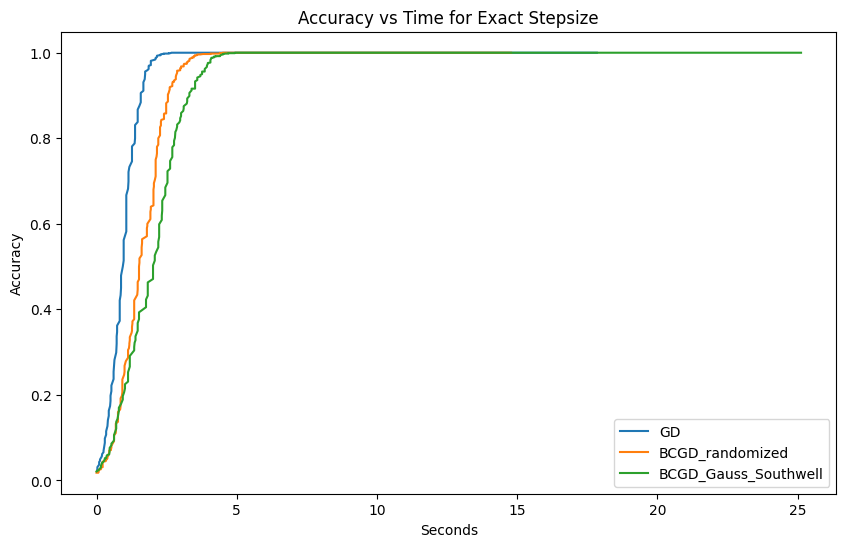

In [16]:
plot_results({k: v['Exact'] for k, v in results.items()}, 'Exact')

In [17]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


def get_full_mnist_dataset(loader):
    for images, b_i in loader:
        return images.view(images.shape[0], -1).to(device), b_i.to(device)


In [18]:
A, Y = get_full_mnist_dataset(train_loader)
k = 10
d, m = A.shape

X = torch.randn(k, m, device=device)
E = torch.randn(d, k, device=device)


Z = F.one_hot(Y, num_classes=k).float().to(device)


In [19]:
block_size  = 8

In [20]:
def f(X, A, Z):
    logits = torch.mm(A, X.t())
    log_probs = -F.log_softmax(logits, dim=1)
    loss = (log_probs * Z).sum() / Z.sum()
    return loss


def gradient(X, A, Z):
    logits = torch.mm(A, X.t())
    probs = F.softmax(logits, dim=1)
    grad = torch.mm(A.t(), (probs - Z))
    return grad.t()



In [21]:
def evaluate_accuracy(X, A, b_i):
    with torch.no_grad():
        logits = torch.mm(A, X.t())
        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == b_i).float().mean().item()
    return accuracy

In [22]:
def GD(X, A, Z, epochs, lr, b_i):
    losses = []
    accuracies = []
    times = []
    start_time = time.process_time()
    for epoch in range(epochs):
        update = gradient(X, A, Z)
        X -= lr * update
        loss = f(X, A, Z)
        current_time = time.process_time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)
        
        losses.append(loss.item())
        accuracies.append(accuracy)
        times.append(current_time)
    return losses, accuracies, times



In [23]:
def BCGD_randomized(X, A, Z, epochs, lr, block_size, b_i):
    losses = []
    accuracies = []
    times = []
    start_time = time.process_time()
    k, m = X.shape
    for epoch in range(epochs):
        block_indices = torch.randint(0, k, (block_size,))
        update_block = gradient(X[block_indices, :], A, Z[:, block_indices])
        X[block_indices, :] -= lr * update_block
        loss = f(X, A, Z)
        current_time = time.process_time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)
        
        losses.append(loss.item())
        accuracies.append(accuracy)
        times.append(current_time)
    return losses, accuracies, times



In [24]:
def BCGD_Gauss_Southwell(X, A, Z, epochs, lr, block_size, b_i):
    losses = []
    accuracies = []
    times = []
    start_time = time.process_time()
    k, m = X.shape
    block_size = min(block_size, k-1)
    for epoch in range(epochs):
        grad_full = gradient(X, A, Z)
        norms = torch.norm(grad_full, dim=1)
        _, block_indices = torch.topk(norms, block_size, largest=True)
        update_block = gradient(X[block_indices, :], A, Z[:, block_indices])
        X[block_indices, :] -= lr * update_block
        loss = f(X, A, Z)
        current_time = time.process_time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)
        
        losses.append(loss.item())
        accuracies.append(accuracy)
        times.append(current_time)
    return losses, accuracies, times


In [25]:
def plot_results(results, stepsize_name):
    plt.figure(figsize=(10, 6))

    for algo_name, (accuracies, times) in results.items():
        plt.plot(times, accuracies, label=algo_name)

    plt.title(f'Accuracy vs Time for {stepsize_name} Stepsize')
    plt.xlabel('Seconds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


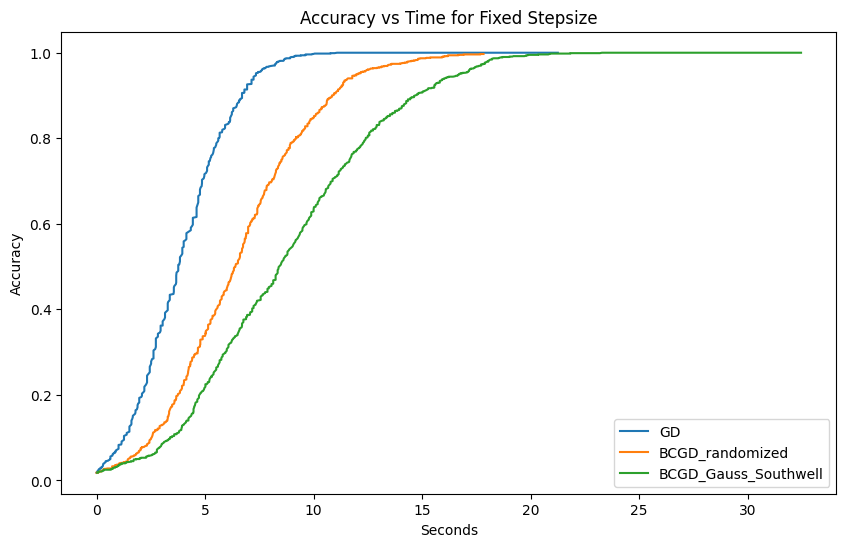

In [26]:
plot_results({k: v['Fixed'] for k, v in results.items()}, 'Fixed')

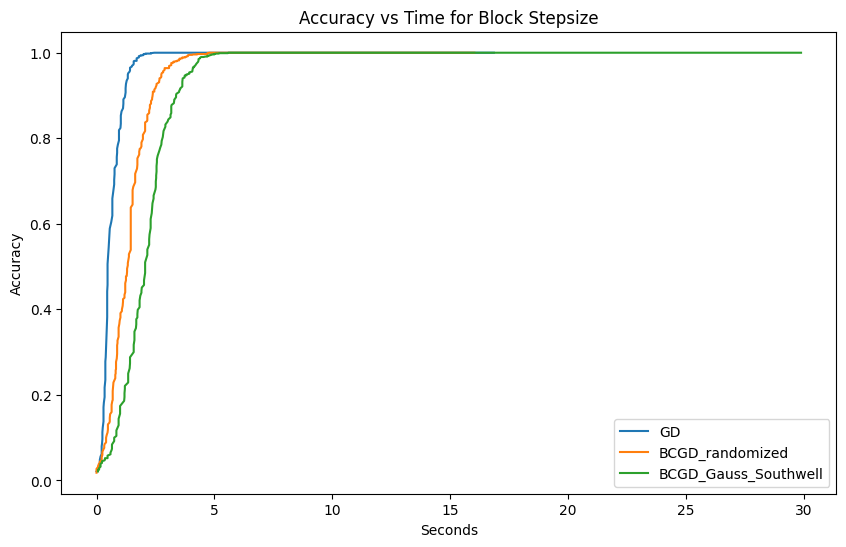

In [27]:
plot_results({k: v['Block'] for k, v in results.items()}, 'Block')

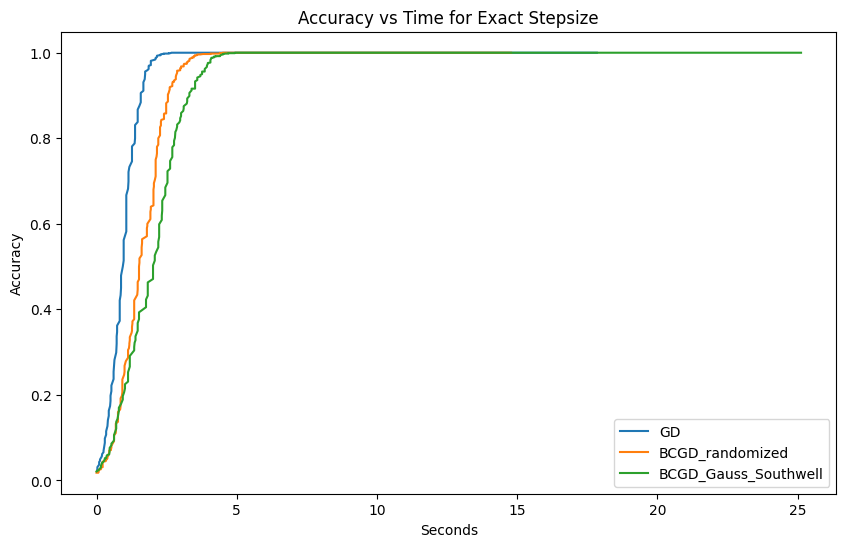

In [28]:
plot_results({k: v['Exact'] for k, v in results.items()}, 'Exact')

In [29]:
newsgroups_train = fetch_20newsgroups(subset='train')
vectorizer = TfidfVectorizer(max_features=100)
X_sparse = vectorizer.fit_transform(newsgroups_train.data)
labels = LabelEncoder().fit_transform(newsgroups_train.target)

X_dense = torch.tensor(X_sparse.toarray(), dtype=torch.float32).to(device)
labels = torch.tensor(labels, dtype=torch.long).to(device)

In [30]:
d, m = X_dense.shape
k = len(np.unique(labels))

A = X_dense
X = torch.randn(m, k, device=device)
E = torch.randn(d, k, device=device)

noised_matrix = torch.mm(A, X) + E
b_i = labels

Z = torch.zeros(d, k, device=device)
Z[torch.arange(d), b_i] = 1

In [31]:
def calculate_lipschitz(A):
    _, S, _ = torch.svd(A)
    return S.max().item() ** 2

L = calculate_lipschitz(A)
def block_stepsize(A, block_indices):
    col_norms = torch.norm(A[:, block_indices], dim=0) ** 2
    return 1 / col_norms

def exact_stepsize(A, X):
    diag = torch.diag(torch.mm(A.t(), A))
    return 1 / diag


In [32]:
def evaluate_accuracy(X, A, b_i):
    with torch.no_grad():
        logits = torch.mm(A, X)
        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == b_i).float().mean().item()
    return accuracy

In [33]:
def GD(X, A, Z, b_i, epochs, lr):
    accuracies = []
    times = []
    start_time = time.process_time()
    for epoch in range(epochs):
        update = gradient(X, A, Z)
        X -= lr * update
        current_time = time.process_time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)
        
        accuracies.append(accuracy)
        times.append(current_time)
    return accuracies, times



In [34]:
def BCGD_randomized(X, A, Z, b_i, epochs, lr, block_size):
    accuracies = []
    times = []
    start_time = time.process_time()
    for epoch in range(epochs):
        block_indices = torch.randint(0, X.shape[1], (block_size,)).tolist()
        update_block = gradient(X[:, block_indices], A, Z[:, block_indices])
        X[:, block_indices] -= lr * update_block
        current_time = time.process_time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)
        
        accuracies.append(accuracy)
        times.append(current_time)
    return accuracies, times



In [35]:
def BCGD_Gauss_Southwell(X, A, Z, b_i, epochs, lr, block_size):
    accuracies = []
    times = []
    start_time = time.process_time()
    for epoch in range(epochs):
        norms = torch.norm(gradient(X, A, Z), dim=0)
        _, block_indices = torch.topk(norms, block_size, largest=True)
        update_block = gradient(X[:, block_indices], A, Z[:, block_indices])
        X[:, block_indices] -= lr * update_block
        current_time = time.process_time() - start_time
        accuracy = evaluate_accuracy(X, A, b_i)
        
        accuracies.append(accuracy)
        times.append(current_time)
    return accuracies, times


In [36]:
def gradient(X, A, Z):
    logits = torch.mm(A, X)
    probs = F.softmax(logits, dim=1)
    grad = torch.mm(A.t(), probs - Z)
    return grad

In [37]:
X_init = torch.randn(m, k, device=device)

In [38]:
alpha_fixed = 1 / L

block_indices = torch.randint(0, k, (block_size,))
alpha_block = block_stepsize(A, block_indices)

alpha_exact = exact_stepsize(A, X_init)


In [39]:
def RUN(X_init, A, Z, b_i, epochs, block_size):
    results = {'GD': {}, 'BCGD_randomized': {}, 'BCGD_Gauss_Southwell': {}}
    
    X_fixed = X_init.clone()
    results['GD']['Fixed'] = GD(X_fixed, A, Z, b_i, epochs, alpha_fixed)
    X_fixed = X_init.clone()
    results['BCGD_randomized']['Fixed'] = BCGD_randomized(X_fixed, A, Z, b_i, epochs, alpha_fixed, block_size)
    X_fixed = X_init.clone()
    results['BCGD_Gauss_Southwell']['Fixed'] = BCGD_Gauss_Southwell(X_fixed, A, Z, b_i, epochs, alpha_fixed, block_size)
    
    X_block = X_init.clone()
    results['GD']['Block'] = GD(X_block, A, Z, b_i, epochs, alpha_block.mean().item())
    X_block = X_init.clone()
    results['BCGD_randomized']['Block'] = BCGD_randomized(X_block, A, Z, b_i, epochs, alpha_block.mean().item(), block_size)
    X_block = X_init.clone()
    results['BCGD_Gauss_Southwell']['Block'] = BCGD_Gauss_Southwell(X_block, A, Z, b_i, epochs, alpha_block.mean().item(), block_size)
    
    X_exact = X_init.clone()
    results['GD']['Exact'] = GD(X_exact, A, Z, b_i, epochs, alpha_exact.mean().item())
    X_exact = X_init.clone()
    results['BCGD_randomized']['Exact'] = BCGD_randomized(X_exact, A, Z, b_i, epochs, alpha_exact.mean().item(), block_size)
    X_exact = X_init.clone()
    results['BCGD_Gauss_Southwell']['Exact'] = BCGD_Gauss_Southwell(X_exact, A, Z, b_i, epochs, alpha_exact.mean().item(), block_size)
    
    return results

In [40]:
results = RUN(X_init, A, Z, b_i, epochs, block_size)

In [41]:
def plot_results(results, stepsize_name):
    plt.figure(figsize=(8, 5))
    
    for algo_name, (accuracies, times) in results.items():
        plt.plot(times, accuracies, label=algo_name)
    
    plt.title(f'Accuracy vs Time for {stepsize_name} Stepsize')
    plt.xlabel('CPU Time (s)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

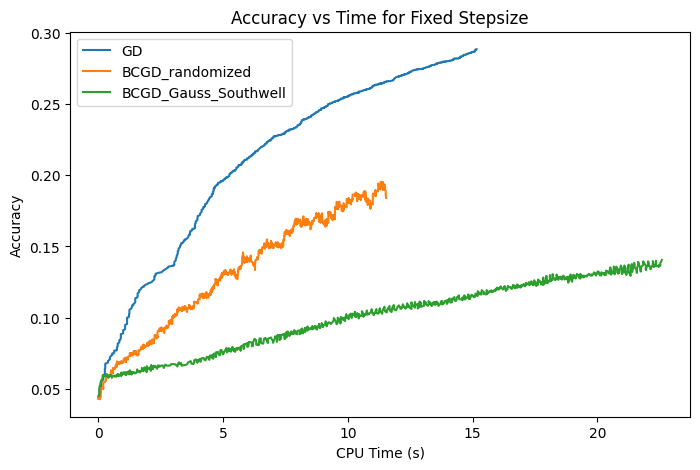

In [42]:
plot_results({k: v['Fixed'] for k, v in results.items()}, 'Fixed')

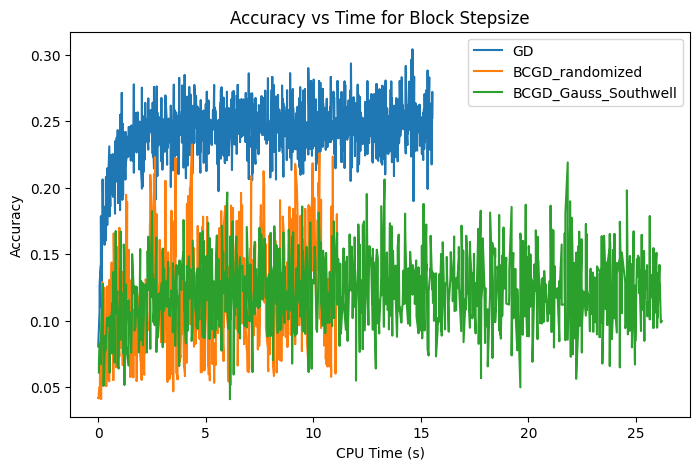

In [43]:
plot_results({k: v['Block'] for k, v in results.items()}, 'Block')

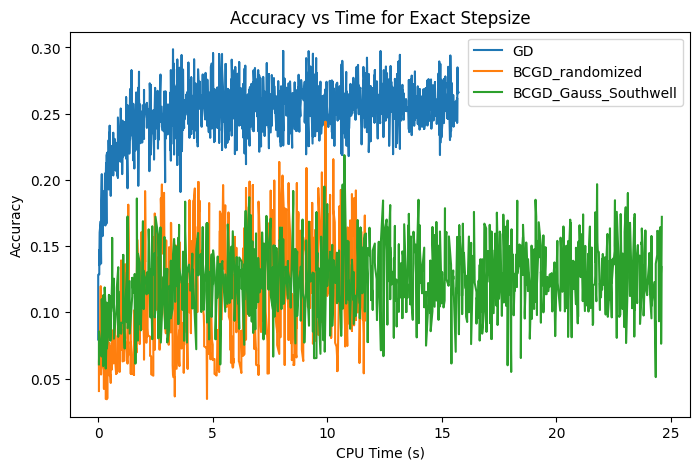

In [44]:
plot_results({k: v['Exact'] for k, v in results.items()}, 'Exact')